# **Project: Sales Performance Analysis & Forecasting**

The goal of this project is to analyse historical sales data to uncover patterns, identify growth opportunities, and forecast future sales. By understanding sales trends and product performance, we aim to support data-driven business decisions for better inventory planning, marketing strategies, and revenue optimisation.

The dataset being used was downloaded from Kaggle (https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting) under a GPL2 licence.

## **Executive Summary**

This project analyses historical sales data to identify seasonal patterns and forecast future revenue. Using SARIMA, Facebook Prophet, and LightGBM models, we compare performance across different forecasting strategies. The Prophet model achieved the best overall accuracy (lowest MAE & MAPE), making it our recommended choice for future sales prediction.

## Dataset Overview

The dataset contains historical sales records, including:
- **Date**: Transaction date.
- **Region**: Sales region or market.
- **Sales**: Revenue generated from sales.

This data will be used to analyse sales performance, identify trends, and forecast future sales.

## 1. Data Loading & Preprocessing

We load the data using the pandas library.

In [74]:
import pandas as pd                     #Importing pandas library

df = pd.read_csv("train.csv")           #Loading the sales data

In [2]:
print(df.head())                  #Previewing the first five rows of the dataframe

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

How many orders are included in the dataset?

In [3]:
print("Length of dataset:", len(df))

Length of dataset: 9800


Are there any missing values in the dataset?

In [4]:
print(df.isna().any())

Row ID           False
Order ID         False
Order Date       False
Ship Date        False
Ship Mode        False
Customer ID      False
Customer Name    False
Segment          False
Country          False
City             False
State            False
Postal Code       True
Region           False
Product ID       False
Category         False
Sub-Category     False
Product Name     False
Sales            False
dtype: bool


There are missing values in the Postal Code column of the dataset.

How many are there?

In [5]:
missing_count = df["Postal Code"].isnull().sum()
print("No. of missing values in Postal Code column:", missing_count)


No. of missing values in Postal Code column: 11


Since there are only 11 missing values (out of 9800), we can drop these rows from the dataset.

In [6]:
df = df.dropna(subset=["Postal Code"])

Let's check whether there are any duplicate rows.

In [7]:
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


There are no duplicate rows.

Let's check whether there are any unusual entries in the categorial columns.

In [8]:
categorical_cols = df.select_dtypes(include = "object").columns

for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())



Value counts for 'Order ID':
Order ID
CA-2018-100111    14
CA-2018-157987    12
CA-2017-165330    11
US-2017-108504    11
CA-2017-105732    10
                  ..
US-2015-161613     1
CA-2018-101728     1
CA-2017-112942     1
CA-2018-126438     1
CA-2017-147123     1
Name: count, Length: 4916, dtype: int64

Value counts for 'Order Date':
Order Date
05/09/2017    38
10/11/2017    35
02/12/2018    34
01/12/2018    34
09/12/2018    33
              ..
25/02/2017     1
25/10/2017     1
11/09/2015     1
16/09/2015     1
09/05/2016     1
Name: count, Length: 1229, dtype: int64

Value counts for 'Ship Date':
Ship Date
26/09/2018    34
06/12/2018    32
16/12/2016    31
06/09/2018    30
12/12/2018    30
              ..
30/07/2016     1
26/01/2017     1
17/01/2015     1
17/08/2018     1
13/05/2016     1
Name: count, Length: 1326, dtype: int64

Value counts for 'Ship Mode':
Ship Mode
Standard Class    5849
Second Class      1901
First Class       1501
Same Day           538
Name: count, dtype:

There aren't any unusual entries in the columns.

Let's change the Order Date and the Ship Date to datetime format so we can add some extra features to our dataset.

In [9]:
df["Order Date"] = pd.to_datetime(df["Order Date"], dayfirst = True)
df["Ship Date"] = pd.to_datetime(df["Ship Date"], dayfirst = True)


Let's add a column that tells us how many days it took to ship the order.

In [10]:
df["Shipping Delay"] = df["Ship Date"] - df["Order Date"]

## Exploratory Data Analysis

### Sales Distribution

Let's start by understanding how individual sales values are distributed. This helps identify skewness and outliers.

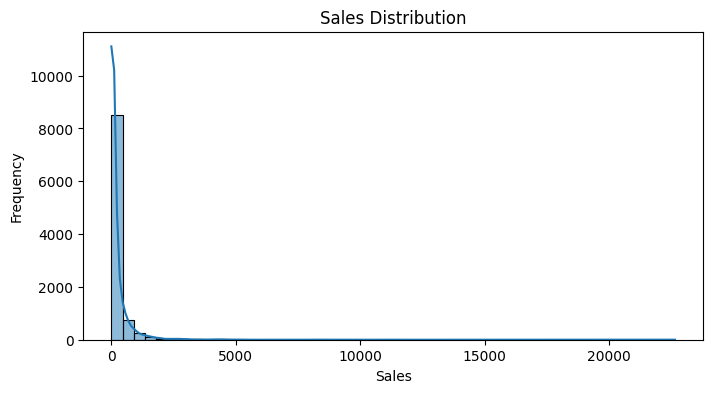

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8,4))
sns.histplot(df["Sales"], bins = 50, kde = True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

The distribution is heavily skewed to the right, indicating most transactions are of low-to-moderate value, with a few high-value purchases. These large sales are expected for high-ticket items, not anomalies.

In [12]:
print(df[df["Sales"] > df["Sales"].quantile(0.99)])


      Row ID        Order ID Order Date  Ship Date       Ship Mode  \
27        28  US-2016-150630 2016-09-17 2016-09-21  Standard Class   
165      166  CA-2015-139892 2015-09-08 2015-09-12  Standard Class   
251      252  CA-2017-145625 2017-09-11 2017-09-17  Standard Class   
262      263  US-2015-106992 2015-09-19 2015-09-21    Second Class   
263      264  US-2015-106992 2015-09-19 2015-09-21    Second Class   
...      ...             ...        ...        ...             ...   
9412    9413  CA-2016-164777 2016-01-27 2016-01-29     First Class   
9425    9426  CA-2015-116246 2015-09-12 2015-09-17    Second Class   
9639    9640  CA-2016-116638 2016-01-28 2016-01-31    Second Class   
9649    9650  CA-2017-107104 2017-11-26 2017-11-30  Standard Class   
9660    9661  CA-2017-160717 2017-06-06 2017-06-11  Standard Class   

     Customer ID        Customer Name      Segment        Country  \
27      TB-21520      Tracy Blumstein     Consumer  United States   
165     BM-11140     

The sales above the 99th percentile represent large-item purchases, rather than being outliers, as they align with expected transactions for high-value goods.

### Sales distribution over time

Next, let's examine how total sales vary over time to spot seasonality or growth patterns.

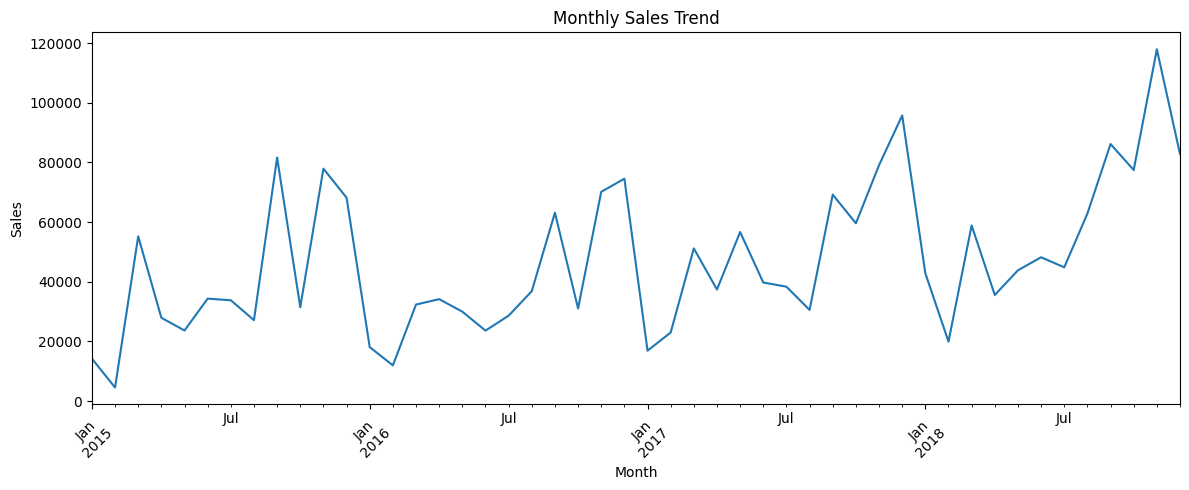

In [13]:
df["Order Month"] = df["Order Date"].dt.to_period("M")              #Creating column containing the month that order was created
monthly_sales = df.groupby("Order Month")["Sales"].sum()            #Computing total sales in each month

plt.figure(figsize = (12,5))
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


### Key Observations

* The sales data from 2015 to 2018 shows a clear upward trajectory, indicating strong overall growth. 
* Sales tend to peak in the final quarter of each year, suggesting a consistent seasonal pattern (likely driven by holiday shopping and year-end purchases). 
* There is noticeable volatility month-to-month. However, the increasing peak values over time point to scaling business performance. 
* These trends highlight opportunities for strategic planning around high-demand periods and further growth forecasting.

## Time Series Forecasting

Let's predict sales over the next 12 months. 

We'll use a SARIMA model to do this as we observed a seasonality in the sales distribution over time. Before, building the model we'll check that the data that we're working with is stationary (i.e. the mean and variance roughly stay constant over time).

### Training and Testing set

We'll first split the data into a training and testing set, using the last 12 months as a testing set.

In [14]:
train = monthly_sales.iloc[:-12]
test = monthly_sales.iloc[-12:]   #Last 12 months of the dataset

Now we'll determine whether the data is stationary using the ADF test.

In [15]:
from statsmodels.tsa.stattools import adfuller                    #Using ADF test to determine stationarity

result = adfuller(train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -4.091899223880485
p-value: 0.0009988203914198441


Since the p-value is less than 0.05, this indicates that the data we are working with is stationary. This is backed up by the ADF statistic which is strongly negative.

We will determine the optimal parameters for the SARIMA model using the auto_arima function.

In [16]:
from pmdarima import auto_arima

# Run auto_arima
stepwise_model = auto_arima(
    train,
    start_p = 0, start_q = 0,
    max_p = 3, max_q = 3,
    start_P = 0, seasonal = True, m = 12,
    d = 0, D = 1,
    trace = True,
    error_action = 'ignore',
    suppress_warnings = True,
    stepwise = True
)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=520.161, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=524.939, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=522.159, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=520.394, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=526.535, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=520.702, Time=0.24 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=519.194, Time=0.11 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=520.510, Time=0.38 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=521.592, Time=0.18 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=519.791, Time=0.18 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=519.043, Time=0.55 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=517.494, Time=0.33 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=529.504, Time=0.08 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=518.815, Time=0.48 sec
 ARIMA(1,0,1)(1,1,0)[12] intercep

The auto_arima function has determined the optimal parameters for our SARIMA model.

Let's break the output down:
* (1,0,1): 
  * p = 1: 1 autoregressive term (past values influence the current value);
  * d = 0: the data is stationary so no differencing is applied;
  * q= 1: 1 moving average term (past forecast errors influence the current value).
*
* (1,1,0)[12]:
  * P = 1: 1 seasonal autoregressive term;
  * D = 1: first-order seasonal differencing (removes yearly seasonality);
  * Q = 0: no seasonal moving average term;
  * s = 12: there are 12 months per cycle.
*
* Intercept: the model includes a constant term.

### Fitting the model

Let's fit the model to our data.

In [17]:
#Defining parameters for model
p = 1
d = 0
q = 1
P = 1
D = 1
Q = 0
s = 12

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fitting the SARIMA model to the training set
model_sarima = SARIMAX(
    train, 
    order = (p, d, q), seasonal_order = (P, D, Q, s),
    enforce_invertibility = False,
    enforce_stationarity=False,
)
results_sarima = model_sarima.fit(maxiter = 200)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77817D+00    |proj g|=  2.71161D+00

At iterate    5    f=  3.30629D+00    |proj g|=  1.36079D-01


 This problem is unconstrained.



At iterate   10    f=  3.26111D+00    |proj g|=  2.55535D-01

At iterate   15    f=  3.25668D+00    |proj g|=  1.00760D-01

At iterate   20    f=  3.25625D+00    |proj g|=  1.68852D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     58      1     0     0   1.689D-04   3.256D+00
  F =   3.2562492187658041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### Forecasting

Let's use the model to predict monthly sales over the next year (12 months).

In [18]:
pred_sarima = results_sarima.get_forecast(steps = 12)             #Forecasting next 12 months using SARIMAX model
pred_ci_sarima = pred_sarima.conf_int()                           #Confidence intervals
pred_mean_sarima = pred_sarima.predicted_mean

Let's plot the forecast.

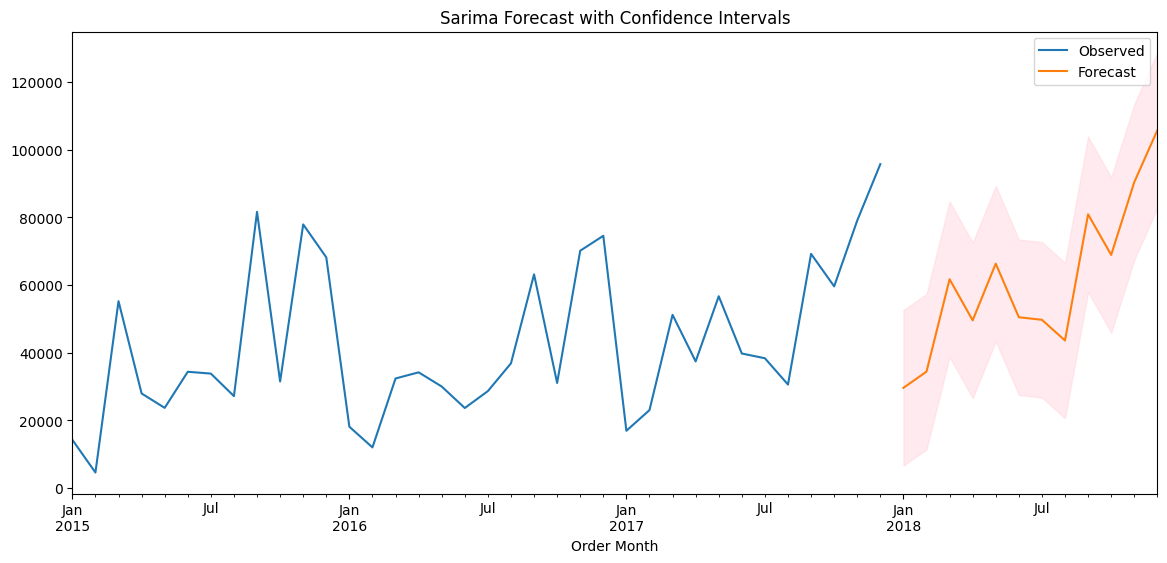

In [19]:
ax = train.plot(label = "Observed", figsize = (14, 6))
pred_mean_sarima.plot(ax = ax, label = "Forecast")
ax.fill_between(pred_ci_sarima.index, pred_ci_sarima.iloc[:, 0], pred_ci_sarima.iloc[:, 1], color = 'pink', alpha = 0.3)
ax.set_title("Sarima Forecast with Confidence Intervals")
ax.legend()

### Evaluating the model

We'll evaluate the model by comparing the predicted results to the testing set.

We evaluate forecast accuracy using:

* Mean Absolute Error (MAE): Average magnitude of prediction errors.

* Root Mean Squared Error (RMSE): Penalises larger errors more strongly.

* Mean Absolute Percentage Error (MAPE): Expresses error as a percentage of actual sales.

This provides a comprehensive view of model performance.

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
 
mae_sarima = mean_absolute_error(test, pred_mean_sarima)                        #Mean absolute error
rmse_sarima = np.sqrt(mean_squared_error(test, pred_mean_sarima))               #Root mean squared error
mape_sarima = np.mean(np.abs((test - pred_mean_sarima) / test)) * 100           #Mean absolute percentage error

print(f"MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%")     #Printing MAE, RMSE, MAPE to 2 d.p.


MAE: 13141.84, RMSE: 15488.43, MAPE: 26.11%


The model captures key **trend and seasonal patterns**, making it a reasonable choice for **high-level planning**. However, a MAPE above 20% indicates **moderate accuracy**, suggesting there is room for further model improvement. Let's try a different model.

### Forecasting using Prophet

We will now apply Facebook Prophet, a time series forecasting model designed to capture trend, seasonality, and holiday effects. In particular, Prophet is well-suited for business time series with strong seasonal patterns.

Prophet requires the input dataframe to follow a specific format:

* A **ds** column for datestamps.

* A **y** column for the target variable (sales).

We will:

* Select relevant columns (Order Date and Sales).

* Rename them as required.

* Aggregate sales to a monthly frequency to smooth out daily fluctuations and highlight long-term trends.



In [57]:
df_prophet = df[["Order Date", "Sales"]].rename(columns = {"Order Date": "ds", "Sales": "y"})   #Creating the new dataframe and renaming columns

# Convert 'ds' to datetime format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Resample the data by month (taking the sum of sales for each month)
df_prophet = df_prophet.resample('M', on = 'ds').sum().reset_index()

We'll use roughly the same training/testing split as we did for the SARIMA model to maintain consistency.

In [58]:
train_prophet_size = int(0.8*len(df_prophet))

train_prophet = df_prophet[:train_prophet_size]
test_prophet = df_prophet[train_prophet_size:]

Before training the Prophet model, we'll search for the optimal parameters using a grid search.

In [47]:
# Defining the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 20.0],
    'seasonality_mode': ["additive", "multiplicative"],
}


Now we'll generate the values of the grid.

In [48]:
import itertools

all_params = [dict(zip(param_grid.keys(), val)) for val in itertools.product(*param_grid.values())]

Now we train the model (using different parameters) and evaluate the accuracy.

In [49]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

results_prophet = []

for params in all_params:
    model_prophet = Prophet(**params)
    model_prophet.fit(train_prophet)

    #Cross-validation (horizon = forecast period)
    df_cv = cross_validation(model_prophet, horizon = "180 days", parallel = "processes")
    df_p = performance_metrics(df_cv, rolling_window = 1)

    #Store performance and params
    results_prophet.append({
        'params': params,
        'MAE': df_p['mae'].mean(),
        'RMSE': df_p['rmse'].mean(),
        'MAPE': df_p['mape'].mean()
    })

17:01:22 - cmdstanpy - INFO - Chain [1] start processing
17:01:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/m

We view the results of the grid search.

In [59]:
# Creating a DataFrame with results
results_df_prophet = pd.DataFrame(results_prophet)
best_params_prophet = results_df_prophet.sort_values(by = "MAE", ascending = True).iloc[0]   #This set of parameters has the lowest MAE
print("Best Parameters:")
print(best_params_prophet)

Best Parameters:
params    {'changepoint_prior_scale': 0.01, 'seasonality...
MAE                                              263.506522
RMSE                                             600.123549
MAPE                                              10.480307
Name: 9, dtype: object


With the model trained, we forecast future sales for the length of the test period:

* Prophet generates future dates using make_future_dataframe.

* Predictions are obtained using the predict method, which outputs the expected sales (yhat).

In [60]:
model_prophet = Prophet(**best_params_prophet["params"])

model_prophet.fit(train_prophet)

future_prophet = model_prophet.make_future_dataframe(periods = len(test_prophet), freq = "M")

forecast_prophet = model_prophet.predict(future_prophet)


18:45:22 - cmdstanpy - INFO - Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing


### Evaluating the Prophet model

We evaluate forecast accuracy using:

* Mean Absolute Error (MAE);

* Root Mean Squared Error (RMSE);

* Mean Absolute Percentage Error (MAPE).

In [65]:
# Merging predictions with actual predictions on the "ds" (date) column

comparison_df_prophet = pd.merge(
    test_prophet[["ds", "y"]],
    forecast_prophet[["ds", "yhat"]],
    on = "ds",
    how = "inner"                       #Only keeping dates present in both sets
)

mae_prophet = mean_absolute_error(comparison_df_prophet["y"], comparison_df_prophet["yhat"])
rmse_prophet = mean_squared_error(comparison_df_prophet["y"], comparison_df_prophet["yhat"], squared = False)
mape_prophet = (abs(comparison_df_prophet["y"] - comparison_df_prophet["yhat"]) / comparison_df_prophet["y"]).mean() * 100

print(f"MAE: {mae_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAPE: {mape_prophet:.2f}%")

MAE: 11433.67
RMSE: 15693.29
MAPE: 16.03%


### Gradient Boosting Model

First we'll extract time features and create lag features.

In [29]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df_monthly = df.groupby(pd.Grouper(key = "Order Date", freq = "M"))["Sales"].sum().reset_index()
df_monthly = df_monthly.rename(columns = {"Order Date": "ds", "Sales": "y"})                     #Creating dataframe with monthly sales

#Time-based features
df_monthly["month"] = df_monthly["ds"].dt.month
df_monthly["year"] = df_monthly["ds"].dt.year

#Lag features (e.g. 1-month ago sales, 2-months ago, etc.)
df_monthly["lag_1"] = df_monthly["y"].shift(1)
df_monthly["lag_2"] = df_monthly["y"].shift(2)

#Computing rolling average over last year
df_monthly["rolling_12"] = df_monthly["y"].shift(1).rolling(window = 12).mean()


# Encoding month cyclically (captures seasonality smoothly)
df_monthly["month_sin"] = np.sin(2 * np.pi * df_monthly["month"] / 12)
df_monthly["month_cos"] = np.cos(2 * np.pi * df_monthly["month"] / 12)


#### Training vs Testing

We'll use the same training/testing split as we did for the SARIMA and Prophet models to maintain consistency.

In [67]:
train_lgbm_size = int(0.8*len(df_monthly))

train_lgbm = df_monthly[:train_lgbm_size]
test_lgbm = df_monthly[train_lgbm_size:]

features_lgbm = ["month", "year", "lag_1", "lag_2", "rolling_12", "month_sin", "month_cos"]

#### Searching for the best parameters

Before training the model, we want to find the optimal input parameters. We'll do this using a grid search.

In [69]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer

X_train_lgbm = train_lgbm[features_lgbm]  
y_train_lgbm = train_lgbm["y"]

tscv = TimeSeriesSplit(n_splits = 3)                     # Time series split (preserves temporal order)

model = lgb.LGBMRegressor(random_state = 42)             # LightGBM regressor

scorer = make_scorer(mean_absolute_error, greater_is_better = False) #We're minimising the Mean Absolute Error (MAE)

param_grid = {
    'num_leaves': [15, 31],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = scorer,
    cv = tscv,
    verbose = 2,
    n_jobs = -1,
    refit = True
)

grid_search.fit(X_train_lgbm, y_train_lgbm)

print("Best Parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maleehakhawaja/Documents/Codecademy/miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data po

Now that we've found our optimal hyperparameters through GridSearchCV, we retrain the LightGBM model using these parameters to forecast monthly sales.

In [70]:
model_lgbm = lgb.LGBMRegressor(
    colsample_bytree = 0.8,
    learning_rate = 0.01,
    max_depth = 3,
    n_estimators = 100,
    num_leaves = 15, 
    subsample = 0.8,
    random_state = 42
)

model_lgbm.fit(X_train_lgbm, y_train_lgbm)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score 41951.523091
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=3,
              num_leaves=15, random_state=42, subsample=0.8)

## Evaluation

We evaluate forecast accuracy using:

* Mean Absolute Error (MAE);

* Root Mean Squared Error (RMSE);

* Mean Absolute Percentage Error (MAPE).

In [72]:
X_test_lgbm = test_lgbm[features_lgbm]
y_test_lgbm = test_lgbm["y"]

preds_lgbm = model_lgbm .predict(X_test_lgbm)

mae_lgbm = mean_absolute_error(y_test_lgbm, preds_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test_lgbm, preds_lgbm))
mape_lgbm = np.mean(np.abs((y_test_lgbm - preds_lgbm) / y_test_lgbm)) * 100


print(f"MAE: {mae_lgbm:.2f}")
print(f"RMSE: {rmse_lgbm:.2f}")
print(f"MAPE: {mape_lgbm:.2f}%")

MAE: 25175.35
RMSE: 33870.99
MAPE: 31.46%


## Summary

In [73]:
results = []

results.append({
    "Model": "SARIMA",
    "MAE": mae_sarima,
    "RMSE": rmse_sarima,
    "MAPE": mape_sarima
})

results.append({
    "Model": "Prophet",
    "MAE": mae_prophet,
    "RMSE": rmse_prophet,
    "MAPE": mape_prophet
})

results.append({
    "Model": "LightGBM",
    "MAE": mae_lgbm,
    "RMSE": rmse_lgbm,
    "MAPE": mape_lgbm
})

results_df = pd.DataFrame(results)
print(results_df)


      Model           MAE          RMSE       MAPE
0    SARIMA  13141.843750  15488.425718  26.112966
1   Prophet  11433.665764  15693.293863  16.025658
2  LightGBM  25175.351288  33870.991985  31.455485


We evaluated three forecasting models (SARIMA, Prophet, and LightGBM) using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

* Prophet achieved the lowest MAE and MAPE, making it the most accurate model overall for forecasting sales.

* SARIMA had the lowest RMSE, indicating stable predictions with fewer large deviations, though it was less accurate overall than Prophet.

* LightGBM, while powerful in many contexts, performed poorly here. This is likely due to a need for additional feature engineering or time-based tuning.